In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from natsort import natsorted
from scipy.stats import pearsonr
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.cm as cm
from pygam import LinearGAM, s, f
from scipy import stats
sns.set(font_scale=1.5, style="white")

In [2]:
regionname = pd.read_csv('../../Dataset/childhood/atlas/schaefer400_regions.csv')
sarank = pd.read_csv('../../Dataset/childhood/saaxis/Sensorimotor_Association_Axis_AverageRanks.csv')
sarank = pd.concat([regionname.reset_index(drop=True), sarank.reset_index(drop=True)],axis=1)
sarank = sarank.loc[:, ['name', 'finalrank.wholebrain']]

In [3]:
# read expression data
data_dir = '../../Dataset/childhood/rna'
gene_columns = pd.read_csv(os.path.join(data_dir, 'columns_metadata.csv'))
gene_rows = pd.read_csv(os.path.join(data_dir, 'rows_metadata.csv'))
gene_columns['id'] = range(1, len(gene_columns) + 1)
expr_matrix = pd.read_csv(os.path.join(data_dir, 'expression_matrix.csv'), header=None)
expr_matrix = expr_matrix.iloc[:, 1:] 

In [4]:
52376-21392

30984

In [5]:
print(gene_rows.shape)
gene_rows[gene_rows.entrez_id>0].shape

(52376, 5)


(21392, 5)

In [6]:
# remove genes without an entrez id
expr_subset = expr_matrix[~gene_rows['entrez_id'].isna()]
rows_subset = gene_rows[~gene_rows['entrez_id'].isna()]

In [7]:
# log2 transform expression data and collapse duplicated transcripts
log2_expr = np.log2(expr_subset + 1)
log2_expr['entrez_id'] = rows_subset['entrez_id']

In [8]:
# select inhibitory-related markers
markers  = ['PVALB', 'SST', 'VIP', 'GAD1', 'GAD2'] 
for marker in markers:
    ids = gene_rows[gene_rows.gene_symbol==marker].entrez_id.values[0]
    df_marker = log2_expr[log2_expr.entrez_id==ids].iloc[:, :-1].T.values
    gene_columns[marker] = df_marker

In [9]:
sa_cortex = np.unique([x for x in gene_columns.structure_name if 'cortex' in x])
sa_cortex = pd.DataFrame([x for x in sa_cortex if 'cereb' not in x])
sa_cortex.columns = ['structure_name']
sa_cortex['sa'] = [7,10,8,-1,6,-1,4,5,1,3,-1,2,0,-1,9]
gene_columns = pd.merge(gene_columns, sa_cortex, on='structure_name', how='left')

In [10]:
gene_columns = gene_columns[gene_columns.age!='4 yrs']
gene_columns = gene_columns[gene_columns.age!='15 yrs']

In [11]:
age = pd.DataFrame(gene_columns.age.unique())
age['rank'] = np.arange(1,age.shape[0]+1)
age.columns = ['age', 'rank']
gene_columns = pd.merge(gene_columns, age, on='age', how='left')

In [12]:
adults = [  '19 yrs', '21 yrs','23 yrs'] #'18 yrs',
cbpd_wide = ['3 yrs','4 yrs', '8 yrs', '11 yrs','13 yrs']

In [13]:
wide = gene_columns.loc[[x for x in gene_columns.index if gene_columns.loc[x,'age'] in adults], :]
wide = wide[wide.sa>-1].sort_values('sa')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


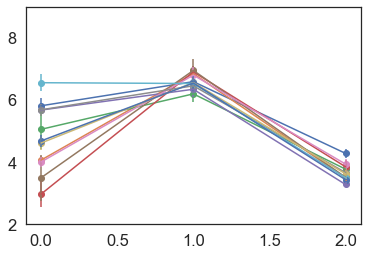

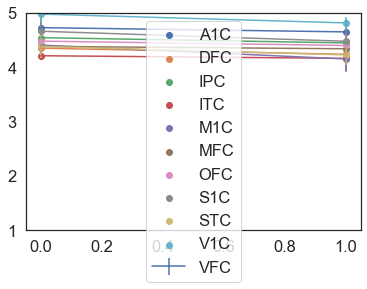

In [14]:
adult_mean = wide.loc[:, ['structure_acronym', 'PVALB', 'SST', 'VIP', 'GAD1', 'GAD2']].groupby('structure_acronym').mean().reset_index()
adult_std = wide.loc[:, ['structure_acronym', 'PVALB', 'SST', 'VIP', 'GAD1', 'GAD2']].groupby('structure_acronym').std().reset_index()
for i in np.arange(adult_mean.shape[0]):
    plt.scatter(np.arange(adult_mean.shape[1]-3), adult_mean.iloc[i, 1:4])
    plt.errorbar(np.arange(adult_mean.shape[1]-3), adult_mean.iloc[i, 1:4], yerr=adult_std.iloc[i, 1:4]/2)
plt.ylim([2,9])
plt.savefig('adult_pv.eps')
figure = plt.figure()
for i in np.arange(adult_mean.shape[0]-1):
    plt.scatter(np.arange(2), adult_mean.iloc[i, 4:])
    plt.errorbar(np.arange(2), adult_mean.iloc[i, 4:], yerr=adult_std.iloc[i, 4:]/2)
plt.ylim([1,5])
plt.legend(adult_mean['structure_acronym'])
plt.savefig('adult_gad.eps')

/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


[23.53137214545247, 6.266313649970989e-10]
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -2.308     0.000    -3.063    -1.552
 (0 - 2)     -1.862     0.000    -2.741    -0.982
 (0 - 3)     -1.304     0.001    -2.184    -0.425
 (1 - 0)      2.308     0.000     1.552     3.063
 (1 - 2)      0.446     0.532    -0.425     1.316
 (1 - 3)      1.003     0.018     0.133     1.874
 (2 - 0)      1.862     0.000     0.982     2.741
 (2 - 1)     -0.446     0.532    -1.316     0.425
 (2 - 3)      0.558     0.440    -0.422     1.538
 (3 - 0)      1.304     0.001     0.425     2.184
 (3 - 1)     -1.003     0.018    -1.874    -0.133
 (3 - 2)     -0.558     0.440    -1.538     0.422

[99.77021301091716, 3.123517361955121e-22]


/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -2.819     0.000    -3.259    -2.378
 (0 - 2)     -2.049     0.000    -2.562    -1.536
 (0 - 3)     -1.696     0.000    -2.209    -1.183
 (1 - 0)      2.819     0.000     2.378     3.259
 (1 - 2)      0.770     0.001     0.262     1.277
 (1 - 3)      1.122     0.000     0.614     1.630
 (2 - 0)      2.049     0.000     1.536     2.562
 (2 - 1)     -0.770     0.001    -1.277    -0.262
 (2 - 3)      0.353     0.368    -0.219     0.924
 (3 - 0)      1.696     0.000     1.183     2.209
 (3 - 1)     -1.122     0.000    -1.630    -0.614
 (3 - 2)     -0.353     0.368    -0.924     0.219

[31.05316435895243, 7.023710181552501e-12]


/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -1.725     0.000    -2.201    -1.249
 (0 - 2)     -1.050     0.000    -1.604    -0.496
 (0 - 3)     -0.830     0.001    -1.384    -0.276
 (1 - 0)      1.725     0.000     1.249     2.201
 (1 - 2)      0.676     0.010     0.127     1.224
 (1 - 3)      0.895     0.000     0.347     1.444
 (2 - 0)      1.050     0.000     0.496     1.604
 (2 - 1)     -0.676     0.010    -1.224    -0.127
 (2 - 3)      0.220     0.782    -0.398     0.837
 (3 - 0)      0.830     0.001     0.276     1.384
 (3 - 1)     -0.895     0.000    -1.444    -0.347
 (3 - 2)     -0.220     0.782    -0.837     0.398

[301.20265789776323, 4.270225112296509e-34]


/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -2.480     0.000    -2.727    -2.232
 (0 - 2)     -2.407     0.000    -2.695    -2.118
 (0 - 3)     -2.308     0.000    -2.596    -2.019
 (1 - 0)      2.480     0.000     2.232     2.727
 (1 - 2)      0.073     0.906    -0.213     0.358
 (1 - 3)      0.172     0.390    -0.114     0.457
 (2 - 0)      2.407     0.000     2.118     2.695
 (2 - 1)     -0.073     0.906    -0.358     0.213
 (2 - 3)      0.099     0.847    -0.222     0.420
 (3 - 0)      2.308     0.000     2.019     2.596
 (3 - 1)     -0.172     0.390    -0.457     0.114
 (3 - 2)     -0.099     0.847    -0.420     0.222

[197.49615963407052, 2.044066578108624e-29]


/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -2.246     0.000    -2.513    -1.979
 (0 - 2)     -1.884     0.000    -2.195    -1.573
 (0 - 3)     -2.029     0.000    -2.340    -1.719
 (1 - 0)      2.246     0.000     1.979     2.513
 (1 - 2)      0.362     0.015     0.054     0.670
 (1 - 3)      0.217     0.254    -0.091     0.524
 (2 - 0)      1.884     0.000     1.573     2.195
 (2 - 1)     -0.362     0.015    -0.670    -0.054
 (2 - 3)     -0.145     0.684    -0.491     0.201
 (3 - 0)      2.029     0.000     1.719     2.340
 (3 - 1)     -0.217     0.254    -0.524     0.091
 (3 - 2)      0.145     0.684    -0.201     0.491



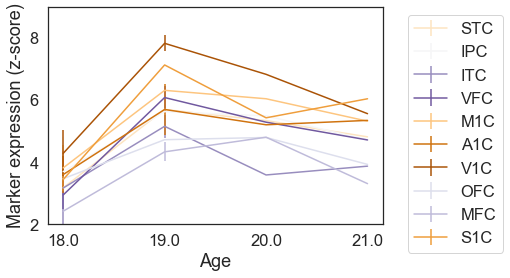

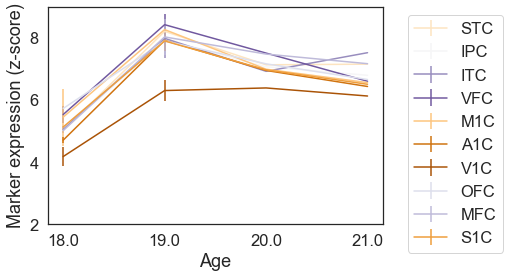

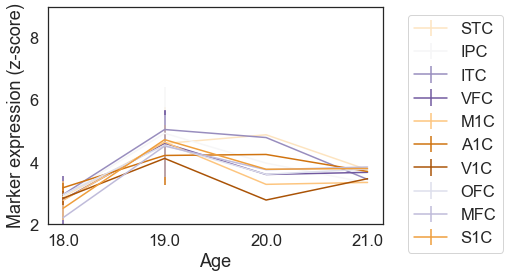

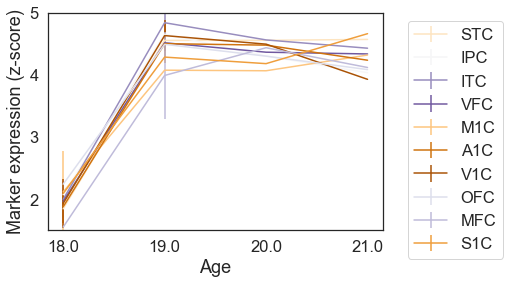

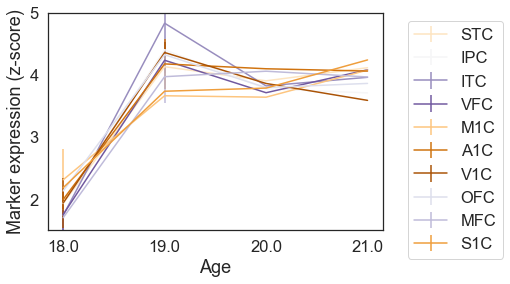

In [15]:
my_palette = {c: sns.color_palette('PuOr', n_colors=(11)).as_hex()[c] for c in np.arange(11)}
for j,sets in enumerate([[0,1,2],[3,4]]):
    gene_columns = gene_columns[gene_columns.sa>-1]
    for i, marker in enumerate([markers[x] for x in sets]):
        figure = plt.figure()
        wide = gene_columns.loc[[x for x in gene_columns.index if gene_columns.loc[x,'age'] in cbpd_wide], :]
        wide = wide[wide.age!='4 yrs']
        for t,structure_name in enumerate(wide.sa.unique()[:-1]):
            wide_st = wide[wide.sa==structure_name]
            wide_st = wide_st.loc[:, ['age', 'sa', 'rank', 'donor_id', 'PVALB', 'SST', 'VIP', 'GAD1', 'GAD2']]
            donor = wide_st.groupby(['rank', 'age']).std().reset_index().sort_values('rank')
            wide_st = wide_st.groupby(['age']).mean().reset_index().sort_values('rank')
            x = [str(t) for t in wide_st['rank'].values]
            y = wide_st[marker].values
            yerr = donor[marker].values
            plt.errorbar(x,y , yerr=yerr, color=my_palette[structure_name]) 
            if j == 0:
                plt.ylim([2,9])
            else:
                plt.ylim([1.5,5])
            plt.ylabel('Marker expression (z-score)')
            plt.xlabel('Age')
            plt.legend([wide[wide.sa==x].structure_acronym.values[0] for x in wide.sa.unique()], bbox_to_anchor=(1.05, 1), loc='upper left')
        [f,p] = stats.f_oneway(wide[wide.age=='3 yrs'][marker].values,wide[wide.age=='8 yrs'][marker].values,
                              wide[wide.age=='11 yrs'][marker].values,wide[wide.age=='13 yrs'][marker].values)
        print([f,p])
        tukey = stats.tukey_hsd(wide[wide.age=='3 yrs'][marker].values,wide[wide.age=='8 yrs'][marker].values,
                              wide[wide.age=='11 yrs'][marker].values,wide[wide.age=='13 yrs'][marker].values)
        print(tukey)

In [16]:
wide.to_csv('RNA.csv', index=False)

/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]


/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]

/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]


/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]
[18. 19. 20. 21.]


/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


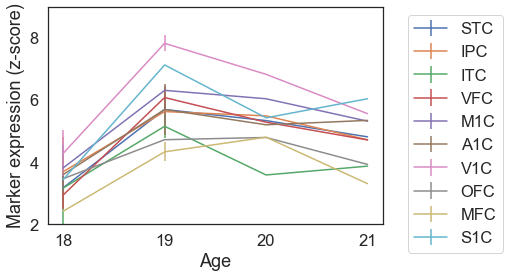

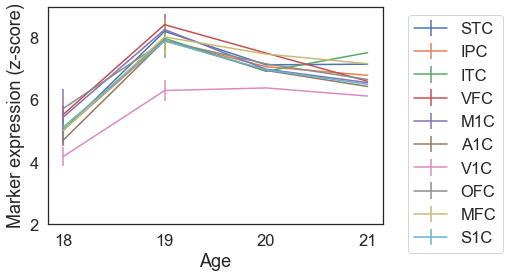

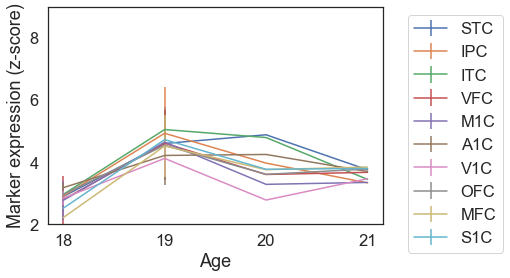

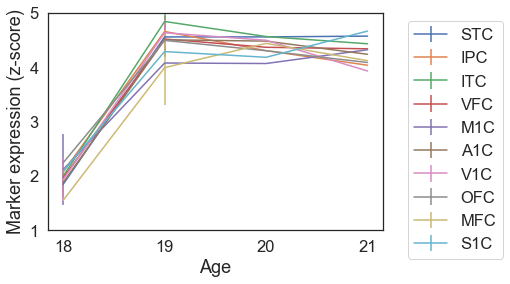

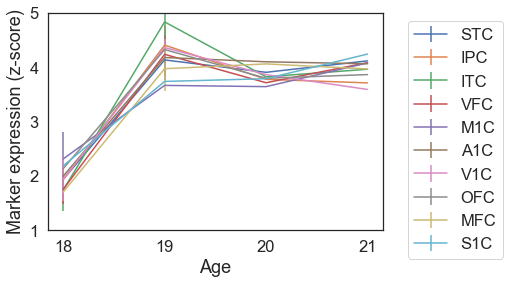

In [30]:
cbpd_wide = [ '3 yrs', '8 yrs', '11 yrs', '13 yrs'] #'2 yrs', '18 yrs', '19 yrs', '21 yrs', '23 yrs', '30 yrs', '36 yrs', '37 yrs', '40 yrs'
my_palette = {c: sns.color_palette('PuOr', n_colors=(11)).as_hex()[c] for c in np.arange(11)}
for j,sets in enumerate([[0,1,2],[3,4]]):
    gene_columns = gene_columns[gene_columns.sa>-1]
    for i, marker in enumerate([markers[x] for x in sets]):
        figure = plt.figure()
        wide = gene_columns.loc[[x for x in gene_columns.index if gene_columns.loc[x,'age'] in cbpd_wide], :]
        for t,structure_name in enumerate(wide.sa.unique()[:-1]):
            wide_st = wide[wide.sa==structure_name]
            wide_st = wide_st.loc[:, ['age', 'sa', 'rank', 'donor_id', 'PVALB', 'SST', 'VIP', 'GAD1', 'GAD2']]
            donor = wide_st.groupby(['rank', 'age']).std().reset_index().sort_values('rank')
            wide_st = wide_st.groupby(['age']).mean().reset_index().sort_values('rank')
            x =  wide_st['rank'].values
            print(x)
            y = wide_st[marker].values
            yerr = donor[marker].values
            plt.errorbar(x,y , yerr=yerr) #, color=my_palette[structure_name]) 
            if j == 0:
                plt.ylim([2,9])
            else:
                plt.ylim([1,5])
            plt.ylabel('Marker expression (z-score)')
            plt.xlabel('Age')
            plt.legend([wide[wide.sa==x].structure_acronym.values[0] for x in wide.sa.unique()], bbox_to_anchor=(1.05, 1), loc='upper left')
        #plt.xticks(np.arange(17,30), cbpd_wide,rotation=90)
        plt.savefig(marker+'.eps')

In [33]:
print(wide.shape)

(59, 16)


[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]
[ 8.  9. 13. 14. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 11. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.
 29.]
[ 8.  9. 12. 13. 14. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 11. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 26. 27. 28. 29.]
[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 11. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 26. 27. 28. 29.]


/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]
[ 8.  9. 13. 14. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 11. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.
 29.]
[ 8.  9. 12. 13. 14. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 11. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 26. 27. 28. 29.]
[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 11. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 26. 27. 28. 29.]


/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]
[ 8.  9. 13. 14. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 11. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.
 29.]
[ 8.  9. 12. 13. 14. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 11. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 26. 27. 28. 29.]
[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 11. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 26. 27. 28. 29.]


/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]
[ 8.  9. 13. 14. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 11. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.
 29.]
[ 8.  9. 12. 13. 14. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]


/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[ 8.  9. 11. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 26. 27. 28. 29.]
[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 11. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 26. 27. 28. 29.]
[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]
[ 8.  9. 13. 14. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 11. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.
 29.]
[ 8.  9. 12. 13. 14. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 11. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 26. 27. 28. 29.]
[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[ 8.  9. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]

/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



[ 8.  9. 11. 13. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 26. 27. 28. 29.]


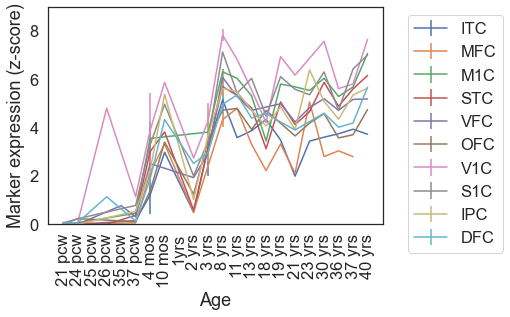

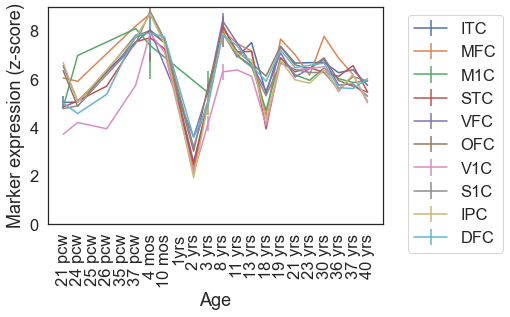

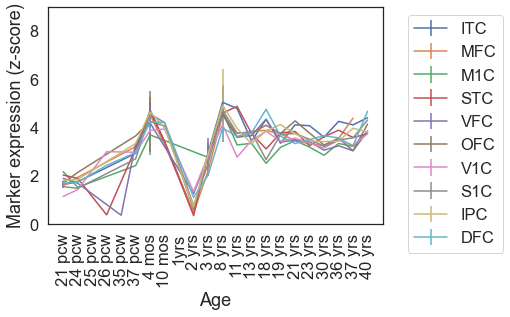

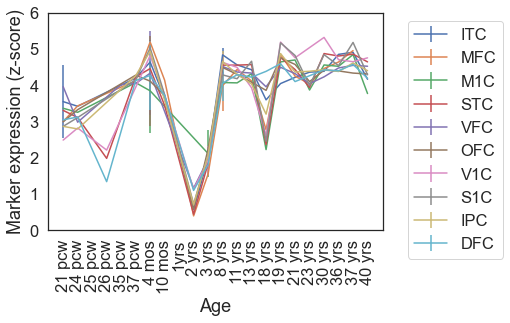

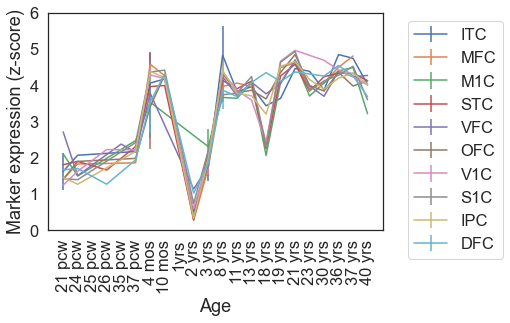

In [19]:
cbpd_wide = [ '21 pcw', '24 pcw', '25 pcw', '26 pcw', '35 pcw', '37 pcw',
       '4 mos', '10 mos','1yrs', '2 yrs', '3 yrs', '8 yrs',
       '11 yrs', '13 yrs', '18 yrs', '19 yrs', '21 yrs',
       '23 yrs', '30 yrs', '36 yrs', '37 yrs', '40 yrs']
my_palette = {c: sns.color_palette('PuOr', n_colors=(11)).as_hex()[c] for c in np.arange(11)}
for j,sets in enumerate([[0,1,2],[3,4]]):
    gene_columns = gene_columns[gene_columns.sa>-1]
    for i, marker in enumerate([markers[x] for x in sets]):
        figure = plt.figure()
        wide = gene_columns.loc[[x for x in gene_columns.index if gene_columns.loc[x,'age'] in cbpd_wide], :]
        for t,structure_name in enumerate(wide.sa.unique()[:-1]):
            wide_st = wide[wide.sa==structure_name]
            wide_st = wide_st.loc[:, ['age', 'sa', 'rank', 'donor_id', 'PVALB', 'SST', 'VIP', 'GAD1', 'GAD2']]
            donor = wide_st.groupby(['rank', 'age']).std().reset_index().sort_values('rank')
            wide_st = wide_st.groupby(['age']).mean().reset_index().sort_values('rank')
            x =  wide_st['rank'].values
            print(x)
            y = wide_st[marker].values
            yerr = donor[marker].values
            plt.errorbar(x,y , yerr=yerr) #, color=my_palette[structure_name]) 
            if j == 0:
                plt.ylim([0,9])
            else:
                plt.ylim([0,6])
            plt.ylabel('Marker expression (z-score)')
            plt.xlabel('Age')
            plt.legend([wide[wide.sa==x].structure_acronym.values[0] for x in wide.sa.unique()], bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(np.arange(8,30), cbpd_wide,rotation=90)
        plt.savefig(marker+'.eps')

In [20]:
adults = [ '19 yrs', '21 yrs','23 yrs']
cbpd_wide =  ['3 yrs', '8 yrs', '11 yrs','13 yrs']

In [28]:
wide = gene_columns.loc[[x for x in gene_columns.index if gene_columns.loc[x,'age'] in cbpd_wide], :]
child_mean = wide.loc[:, ['PVALB', 'sa']].groupby('sa').mean().reset_index()
child_std = wide.loc[:, ['PVALB', 'sa']].groupby('sa').sem().reset_index()
print(stats.f_oneway(wide[wide.sa==0].PVALB, wide[wide.sa==1].PVALB, wide[wide.sa==2].PVALB,wide[wide.sa==3].PVALB, wide[wide.sa==4].PVALB, wide[wide.sa==5].PVALB
, wide[wide.sa==6].PVALB, wide[wide.sa==7].PVALB, wide[wide.sa==8].PVALB,wide[wide.sa==9].PVALB, wide[wide.sa==10].PVALB))
print(wide[wide.sa>=0][wide.sa<11].shape)

F_onewayResult(statistic=1.5107304046718932, pvalue=0.1648056998578804)
(59, 16)


In [29]:
wide = gene_columns.loc[[x for x in gene_columns.index if gene_columns.loc[x,'age'] in adults], :]
adult_mean = wide.loc[:, ['PVALB', 'sa']].groupby('sa').mean().reset_index()
adult_std = wide.loc[:, ['PVALB', 'sa']].groupby('sa').sem().reset_index()
print(stats.f_oneway(wide[wide.sa==0].PVALB, wide[wide.sa==1].PVALB, wide[wide.sa==2].PVALB,wide[wide.sa==3].PVALB, wide[wide.sa==4].PVALB, wide[wide.sa==5].PVALB
, wide[wide.sa==6].PVALB, wide[wide.sa==7].PVALB, wide[wide.sa==8].PVALB,wide[wide.sa==9].PVALB, wide[wide.sa==10].PVALB))
print(wide[wide.sa>=0][wide.sa<11].shape)

F_onewayResult(statistic=5.818011564093507, pvalue=0.0004187819570967542)
(31, 16)


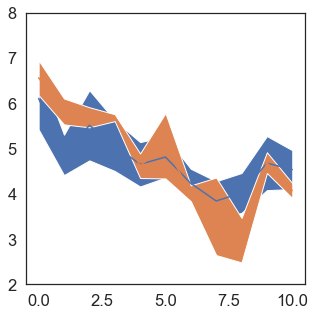

In [23]:
figure = plt.figure(figsize=(5,5))
plt.plot(child_mean['PVALB'])
plt.fill_between(child_mean.sa, child_mean['PVALB']-child_std['PVALB'], child_mean['PVALB']+child_std['PVALB'])
plt.plot(adult_mean['PVALB'])
plt.fill_between(adult_mean.sa, adult_mean['PVALB']-adult_std['PVALB'], adult_mean['PVALB']+adult_std['PVALB'])
plt.ylim([2,8])
plt.savefig('spatial.eps')

(31, 16)